Реализовать синтезирование лиц из LFW с помощью DCGAN  
Библиотеки: [Python, Tensorflow]

In [13]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt
import time

import warnings
warnings.filterwarnings('ignore')

In [2]:
tf.__version__

'2.9.2'

In [4]:
(train_ds, test_ds), ds_info = tfds.load(
    'lfw', 
    as_supervised=True,
    with_info=True,
    split=['train[:90%]', 'train[90%:]'],
)

In [5]:
ds_info

tfds.core.DatasetInfo(
    name='lfw',
    full_name='lfw/0.1.0',
    description="""
    Labeled Faces in the Wild:
            A Database for Studying Face Recognition in
            Unconstrained Environments
    """,
    homepage='http://vis-www.cs.umass.edu/lfw',
    data_path='~/tensorflow_datasets/lfw/0.1.0',
    file_format=tfrecord,
    download_size=172.20 MiB,
    dataset_size=180.28 MiB,
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    supervised_keys=('label', 'image'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=13233, num_shards=2>,
    },
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Am

Визуализация

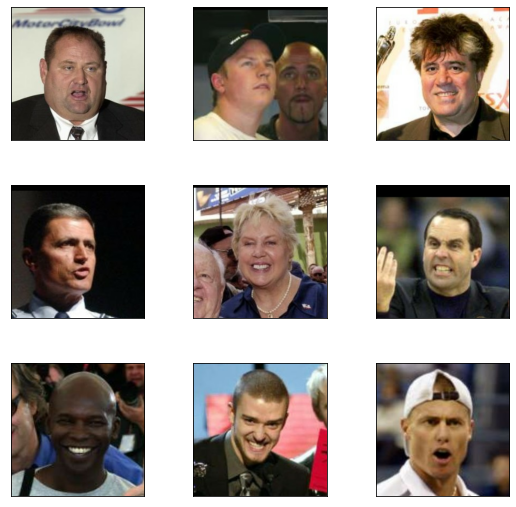

In [6]:
fig = tfds.show_examples(train_ds, ds_info=ds_info)

In [7]:
INPUT_DIM = 128
IMG_SIZE = 128
NUM_EPOCHS = 20
BATCH_SIZE = 20
HALF_BATCH_SIZE = 10

LEARNING_RATE = 0.0001

In [8]:
def prepare(label, img):
    img = tf.cast(img, tf.float32) / 255.
    return tf.image.resize(img, (IMG_SIZE, IMG_SIZE))

In [9]:
train_ds = train_ds.shuffle(buffer_size=len(train_ds))
train_ds = train_ds.map(prepare)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)

In [15]:
num_steps = len(train_ds) - 1
num_steps

23819

Deep Convolutional GAN (DCGAN)

In [10]:
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(256*32*32),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Reshape((32, 32, 256)),
    tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.Conv2D(256, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),   
    tf.keras.layers.Conv2D(3, (3, 3), padding='same', activation='sigmoid'),
])


discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(0.2), 
    tf.keras.layers.Conv2D(64, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Conv2D(128, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Conv2D(256, kernel_size=2, strides=(1, 1), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1),
])

Обучение

In [11]:
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [12]:
def plot_results(samples):
    fig = plt.figure(figsize=(16, 10))
    num = samples.shape[0]
    for j in range(num):
        ax = fig.add_subplot(8, 8, j+1)
        ax.imshow((samples[j, ...].reshape(IMG_SIZE, IMG_SIZE, 3)))
        plt.xticks([]),
        plt.yticks([])
    plt.show()

1/1 [==============================] - 0s 73ms/step
[Step  0] D Loss: 0.0000; G Loss: 2.0004; time taken ----> 1.01 sec
1/1 [==============================] - 0s 15ms/step


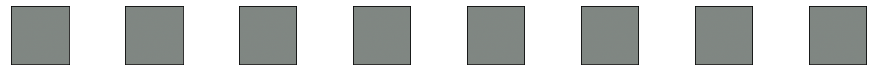

1/1 [==============================] - 0s 19ms/step
[Step 2000] D Loss: 0.3861; G Loss: 37.9935; time taken ----> 725.09 sec
1/1 [==============================] - 0s 19ms/step


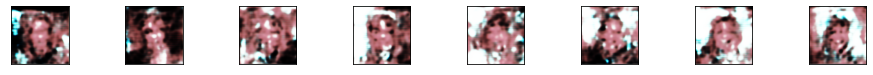

1/1 [==============================] - 0s 15ms/step
[Step 4000] D Loss: 0.1331; G Loss: 14.3556; time taken ----> 724.36 sec
1/1 [==============================] - 0s 15ms/step


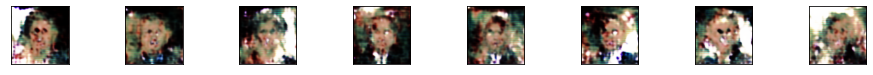

1/1 [==============================] - 0s 18ms/step
[Step 6000] D Loss: 0.4753; G Loss: 4.7299; time taken ----> 723.88 sec
1/1 [==============================] - 0s 19ms/step


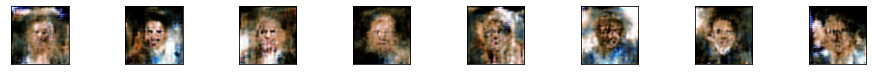

1/1 [==============================] - 0s 17ms/step
[Step 8000] D Loss: 0.4857; G Loss: 0.3353; time taken ----> 726.31 sec
1/1 [==============================] - 0s 17ms/step


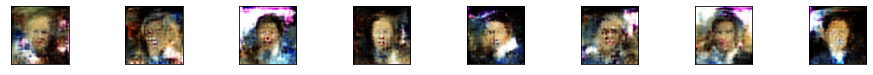

1/1 [==============================] - 0s 16ms/step
[Step 10000] D Loss: 0.0801; G Loss: 3.2139; time taken ----> 726.36 sec
1/1 [==============================] - 0s 16ms/step


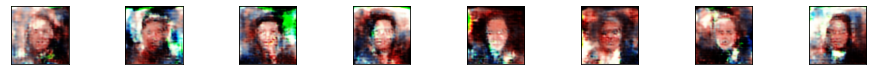

1/1 [==============================] - 0s 16ms/step
[Step 12000] D Loss: 0.7196; G Loss: 2.1647; time taken ----> 728.64 sec
1/1 [==============================] - 0s 16ms/step


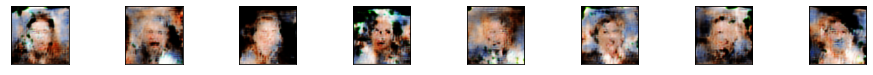

1/1 [==============================] - 0s 22ms/step
[Step 14000] D Loss: 0.0651; G Loss: 0.7144; time taken ----> 728.43 sec
1/1 [==============================] - 0s 27ms/step


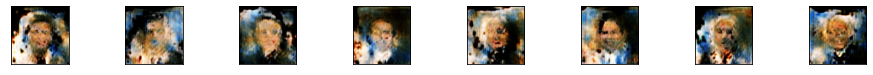

1/1 [==============================] - 0s 16ms/step
[Step 16000] D Loss: 0.2126; G Loss: 0.6730; time taken ----> 728.64 sec
1/1 [==============================] - 0s 18ms/step


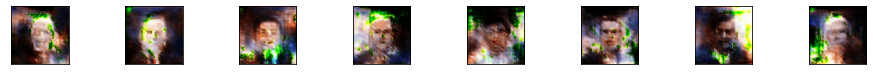

1/1 [==============================] - 0s 15ms/step
[Step 18000] D Loss: 0.2635; G Loss: 3.8995; time taken ----> 724.14 sec
1/1 [==============================] - 0s 22ms/step


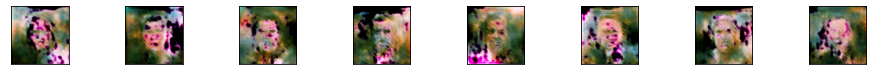

1/1 [==============================] - 0s 22ms/step
[Step 20000] D Loss: 0.5286; G Loss: 1.7834; time taken ----> 721.28 sec
1/1 [==============================] - 0s 26ms/step


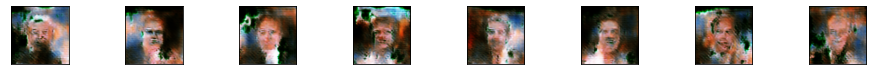

1/1 [==============================] - 0s 19ms/step
[Step 22000] D Loss: 0.4949; G Loss: 0.0107; time taken ----> 721.72 sec
1/1 [==============================] - 0s 17ms/step


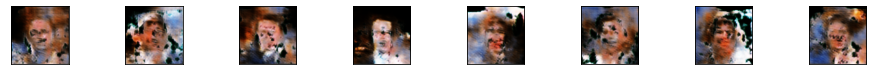

1/1 [==============================] - 0s 23ms/step
[Step 23819] D Loss: 0.2473; G Loss: 8.7607; time taken ----> 656.53 sec
1/1 [==============================] - 0s 16ms/step


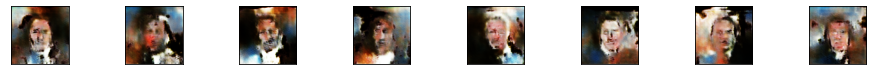

CPU times: user 57min 10s, sys: 4min 14s, total: 1h 1min 25s
Wall time: 2h 24min 21s


In [16]:
%%time

start = time.time()
for step, true_images in enumerate(train_ds):
    
    # Train Discriminator
    
    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    syntetic_images = generator.predict(noise)
    x_combined = np.concatenate((
        true_images, 
        syntetic_images))
    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1), np.float32), 
        np.zeros((HALF_BATCH_SIZE, 1), np.float32)))
    
    with tf.GradientTape() as tape:
        logits = discriminator(x_combined, training=True)
        d_loss_value = sigmoid_cross_entropy(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    # Train Generator
    
    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    y_mislabled = np.ones((BATCH_SIZE, 1), np.float32)
    
    with tf.GradientTape() as tape:
        syntetic = generator(noise, training=True)
        logits = discriminator(syntetic, training=False)
        g_loss_value = sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    
    if (step % 2000 == 0) or (step == num_steps):
        print('[Step %2d] D Loss: %.4f; G Loss: %.4f;' % (
            step, d_loss_value.numpy(), g_loss_value.numpy()), f'time taken ----> {round((time.time()-start), 2)} sec')
        noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise) 
        plot_results(syntetic_images)
        start = time.time()

Генерация изображений

1/1 [==============================] - 1s 981ms/step


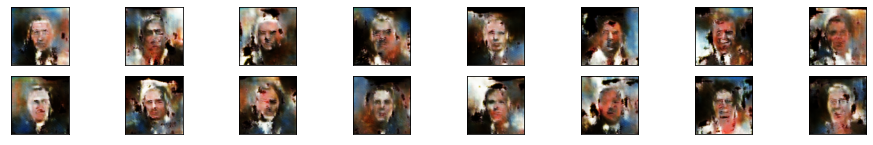

In [17]:
noise = np.random.normal(0, 1, (16, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
plot_results(syntetic_images)

Интерполяция в латентном пространстве

1/1 [==============================] - 0s 67ms/step


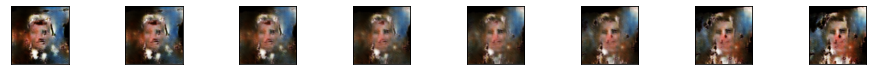

In [18]:
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 8)
syntetic_images = generator.predict(noise)
plot_results(syntetic_images)